import stuff

In [24]:
from dotenv import load_dotenv
import sys
sys.path.append("../../")
from shared.models import MiniPileDataset
from shared.interp import count_non_zero_feature_activations, plot_feature_activation_histogram, plot_feature_activation_histogram_from_log_feature_densities, plot_highest_activating_feature_for_each_sentence, create_feature_heatmap_widget
from shared.features import Feature, FeatureSample
import os
import json

# Enable automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2


# Load environment variables from .env file
load_dotenv()

# Access the OpenAI API key from the environment variables
openai_api_key = os.getenv("OPENAI_API_KEY")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


pre-trained

In [99]:
# Load the model from the pickle file
import pickle 
import sys

sys.path.append("../")
from shared.sparse_autoencoder import SparseAutoencoder, SparseAutoencoderConfig
import json

%load_ext autoreload
%autoreload 2

# load the dataset
pre_trained_sentences_file = "pre-trained/data/asap_sentences_3_bert-base-uncased.npy"
pre_trained_embeddings_file = "pre-trained/data/asap_embeddings_3_bert-base-uncased.npy"
pre_trained_mini_pile_dataset = MiniPileDataset(pre_trained_sentences_file, pre_trained_embeddings_file)

# Load the configuration from the JSON file
pre_trained_config_path = "pre-trained/sae/config.json"
with open(pre_trained_config_path, "r") as pre_trained_config_file:
    pre_trained_config = json.load(pre_trained_config_file)

# Load the pre-trained model from the pickle file
pre_trained_sae_config = SparseAutoencoderConfig(d_model=pre_trained_config["dimensions"], d_sparse=8 * pre_trained_config["dimensions"], sparsity_alpha=pre_trained_config["sparsity_alpha"])
pre_trained_model = SparseAutoencoder(pre_trained_sae_config)
pre_trained_model_path = "pre-trained/sae/sae.pkl"
with open(pre_trained_model_path, "rb") as pre_trained_f:
    pre_trained_model_state_dict = pickle.load(pre_trained_f)
    pre_trained_model.load_state_dict(pre_trained_model_state_dict)

# Load the log feature densities from the JSON file
pre_trained_log_feature_densities_path = "pre-trained/sae/log_feature_densities.json"
with open(pre_trained_log_feature_densities_path, "r") as pre_trained_json_file:
    pre_trained_log_feature_densities = json.load(pre_trained_json_file)

# Load features
pre_trained_features_folder = "pre-trained/features"
pre_trained_features = []
pre_trained_filtered_out_count = 0

for pre_trained_filename in os.listdir(pre_trained_features_folder):
    if pre_trained_filename.startswith("feature_") and pre_trained_filename.endswith(".json"):
        with open(os.path.join(pre_trained_features_folder, pre_trained_filename), "r") as pre_trained_json_file:
            pre_trained_feature_data = json.load(pre_trained_json_file)
            pre_trained_feature = Feature(**pre_trained_feature_data)
            pre_trained_features.append(pre_trained_feature)
            # if len(pre_trained_feature.high_act_samples) >= 10:
            #     pre_trained_features.append(pre_trained_feature)
            # else:
            #     pre_trained_filtered_out_count += 1

# Load the scores from the JSON file
with open("../pickled_data/asap_sentences_scores_3.json", "r") as score_file:
    score_dict = json.load(score_file)

# Add scores to high acting samples in pre_trained_features
for feature in pre_trained_features:
    for sample in feature.high_act_samples:
        sample_text = sample.text
        if sample_text in score_dict:
            sample.score = score_dict[sample_text]
        else:
            sample.score = None  # or some default value if the text is not found

print("Scores added to high acting samples in pre_trained_features.")

# pre_trained_features.sort(key=lambda x: x.confidence, reverse=True)

# print(f"Number of filtered out samples: {pre_trained_filtered_out_count}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Scores added to high acting samples in pre_trained_features.


In [102]:
# load the dataset
fine_tuned_sentences_file = "fine-tuned/data/asap_sentences_3.npy"
fine_tuned_embeddings_file = "fine-tuned/data/asap_embeddings_3.npy"
fine_tuned_mini_pile_dataset = MiniPileDataset(fine_tuned_sentences_file, fine_tuned_embeddings_file)

# Load the configuration from the JSON file
fine_tuned_config_path = "fine-tuned/sae/config.json"
with open(fine_tuned_config_path, "r") as fine_tuned_config_file:
    fine_tuned_config = json.load(fine_tuned_config_file)

# Load the fine-tuned model from the pickle file
fine_tuned_sae_config = SparseAutoencoderConfig(d_model=fine_tuned_config["dimensions"], d_sparse=8 * fine_tuned_config["dimensions"], sparsity_alpha=fine_tuned_config["sparsity_alpha"])
fine_tuned_model = SparseAutoencoder(fine_tuned_sae_config)
fine_tuned_model_path = "fine-tuned/sae/sae.pkl"
with open(fine_tuned_model_path, "rb") as fine_tuned_f:
    fine_tuned_model_state_dict = pickle.load(fine_tuned_f)
    fine_tuned_model.load_state_dict(fine_tuned_model_state_dict)

# Load the log feature densities from the JSON file
fine_tuned_log_feature_densities_path = "fine-tuned/sae/log_feature_densities.json"
with open(fine_tuned_log_feature_densities_path, "r") as fine_tuned_json_file:
    fine_tuned_log_feature_densities = json.load(fine_tuned_json_file)

# Load features
fine_tuned_features_folder = "fine-tuned/features"
fine_tuned_features = []
fine_tuned_filtered_out_count = 0

for fine_tuned_filename in os.listdir(fine_tuned_features_folder):
    if fine_tuned_filename.startswith("feature_") and fine_tuned_filename.endswith(".json"):
        with open(os.path.join(fine_tuned_features_folder, fine_tuned_filename), "r") as fine_tuned_json_file:
            fine_tuned_feature_data = json.load(fine_tuned_json_file)
            fine_tuned_feature = Feature(**fine_tuned_feature_data)
            fine_tuned_features.append(fine_tuned_feature)
            # if len(fine_tuned_feature.high_act_samples) >= 10:
            #     fine_tuned_features.append(fine_tuned_feature)
            # else:
            #     fine_tuned_filtered_out_count += 1

# Add scores to high acting samples in pre_trained_features
for feature in fine_tuned_features:
    for sample in feature.high_act_samples:
        sample_text = sample.text
        if sample_text in score_dict:
            sample.score = score_dict[sample_text]
        else:
            sample.score = None  # or some default value if the text is not found

print("Scores added to high acting samples in fine_tuned_features.")

# fine_tuned_features.sort(key=lambda x: x.confidence, reverse=True)

Scores added to high acting samples in fine_tuned_features.


In [105]:
# Write fine-tuned features to JSON
fine_tuned_features_json = [feature.dict() for feature in fine_tuned_features]
with open("fine_tuned_features.json", "w") as f:
    json.dump(fine_tuned_features_json, f, indent=2)

print("Fine-tuned features written to fine_tuned_features.json")

# Write pre-trained features to JSON
pre_trained_features_json = [feature.dict() for feature in pre_trained_features]
with open("pre_trained_features.json", "w") as f:
    json.dump(pre_trained_features_json, f, indent=2)

print("Pre-trained features written to pre_trained_features.json")

Fine-tuned features written to fine_tuned_features.json
Pre-trained features written to pre_trained_features.json


In [106]:
sys.path.append("../../")
from shared.utils import build_heatmap_using_encoder_method

# Define the text to analyze
text_to_analyze = """
A panda bear is similar to a koala bear because they both only eat one food for the most part. Pandas eat bamboo, while koalas eat eucalyptus leaves. But a python is a more diverse and invasive animal. It eats a broader range of things from smaller reptiles to amphibians.
"""

# Build heatmap for fine-tuned model
fine_tuned_heatmap_data = build_heatmap_using_encoder_method(
    text_to_analyze,
    fine_tuned_model,
    "fine-tuned",
    "./fine-tuned/heatmaps",
    first_n_features=500
)

print("Heatmap data for fine-tuned model generated successfully.")


Heatmap data for fine-tuned model generated successfully.


In [107]:
# Build heatmap for pre-trained model
pre_trained_heatmap_data = build_heatmap_using_encoder_method(
    text_to_analyze,
    pre_trained_model,
    "pre-trained",
    "./pre-trained/heatmaps",
    first_n_features=500
)

print("Heatmap data for pre-trained model generated successfully.")

Heatmap data for pre-trained model generated successfully.


Analyzing feature activations for each sentence:

Sentence 1: 
A panda bear is similar to a koala bear because they both only eat one food for the most part.
--------------------------------------------------------------------------------
Top 5 activating features for Fine-tuned Model:
  Feature   69 | Activation: 0.1978 | Label: Specialist vs generalist species comparison
  Feature   19 | Activation: 0.0720 | Label: Python adaptability and diet variety
  Feature  293 | Activation: 0.0166 | Label: Specialized diet of pandas and koalas
  Feature  343 | Activation: 0.0158 | Label: Specialist diet and habitat contrast
  Feature  248 | Activation: 0.0108 | Label: Pythons' adaptability and versatile diet

Top 5 activating features for Pre-Trained Model:
  Feature  483 | Activation: 0.0926 | Label: Detailed comparative attributes of animals
  Feature  297 | Activation: 0.0466 | Label: Comparison of pandas, koalas, and pythons
  Feature  149 | Activation: 0.0331 | Label: Exclusive dietary hab

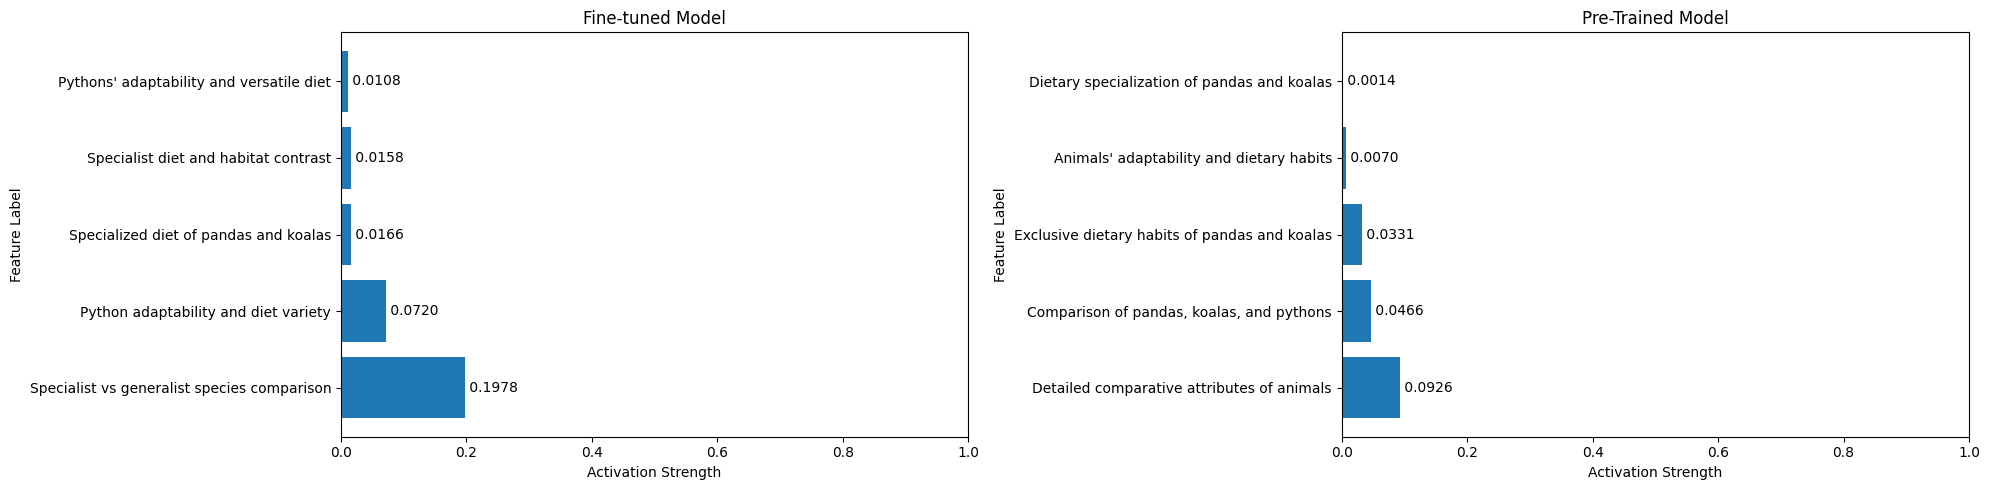


Sentence 2: Pandas eat bamboo, while koalas eat eucalyptus leaves.
--------------------------------------------------------------------------------
Top 5 activating features for Fine-tuned Model:
  Feature  410 | Activation: 0.1294 | Label: Consistent comparative attributes
  Feature  474 | Activation: 0.1109 | Label: Comparison of pandas, koalas, pythons
  Feature  347 | Activation: 0.0914 | Label: Pandas and koalas similarities to pythons
  Feature   71 | Activation: 0.0699 | Label: Specialist vs. generalist species comparison
  Feature  360 | Activation: 0.0532 | Label: Pandas and koalas exclusive diets

Top 5 activating features for Pre-Trained Model:
  Feature   78 | Activation: 0.1816 | Label: Dietary habits of pandas and koalas
  Feature  149 | Activation: 0.0485 | Label: Exclusive dietary habits of pandas and koalas
  Feature  260 | Activation: 0.0439 | Label: Generalist vs. specialist adaptability and diet
  Feature  243 | Activation: 0.0215 | Label: Comparison of harmless an

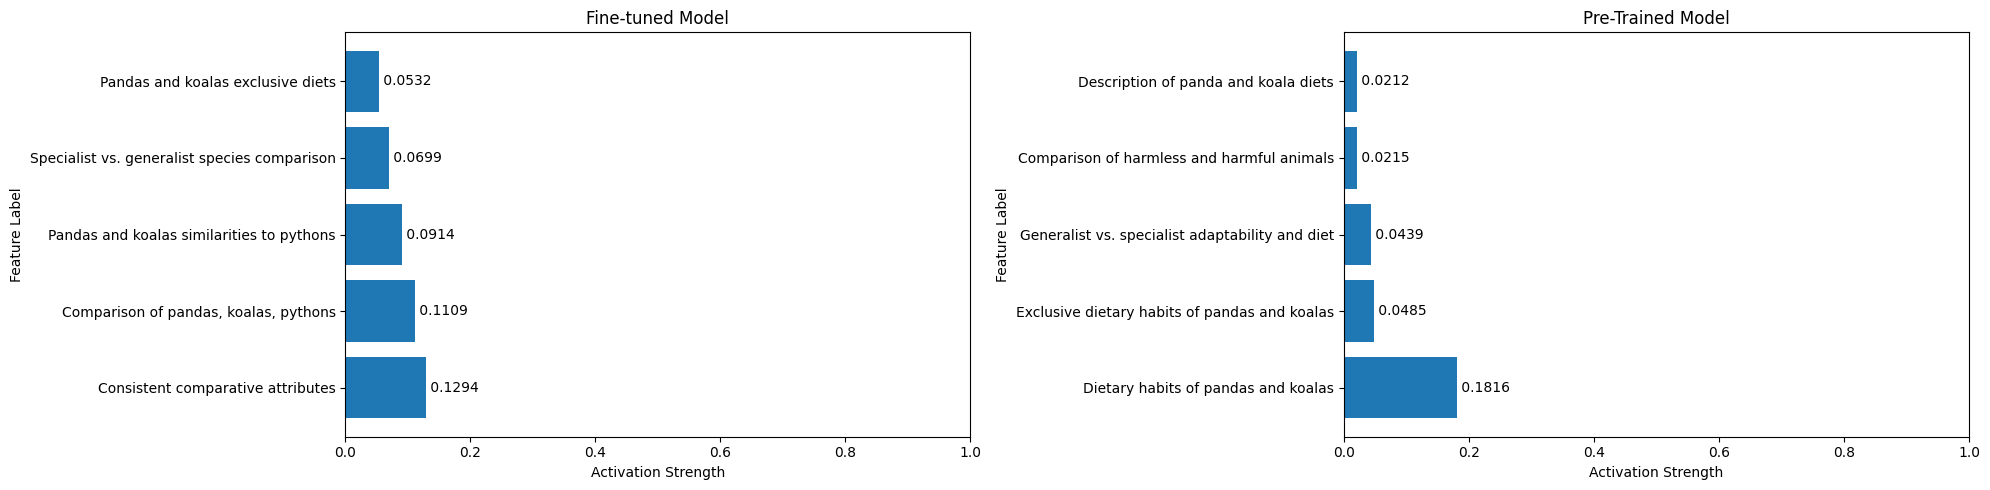


Sentence 3: But a python is a more diverse and invasive animal.
--------------------------------------------------------------------------------
Top 5 activating features for Fine-tuned Model:
  Feature  488 | Activation: 0.1970 | Label: Comparative traits with pythons
  Feature  268 | Activation: 0.1731 | Label: Contrasting animal danger levels
  Feature   13 | Activation: 0.1628 | Label: Comparative biological distinction
  Feature  109 | Activation: 0.1559 | Label: Comparison with pythons
  Feature  410 | Activation: 0.1514 | Label: Consistent comparative attributes

Top 5 activating features for Pre-Trained Model:
  Feature   74 | Activation: 0.0655 | Label: Focus on harmful python attributes
  Feature  311 | Activation: 0.0402 | Label: Emphasis on specialist nature
  Feature  339 | Activation: 0.0387 | Label: Pythons' varied and extensive diet
  Feature  392 | Activation: 0.0280 | Label: Comparative adaptability and diet of pythons
  Feature  395 | Activation: 0.0273 | Label: Pyt

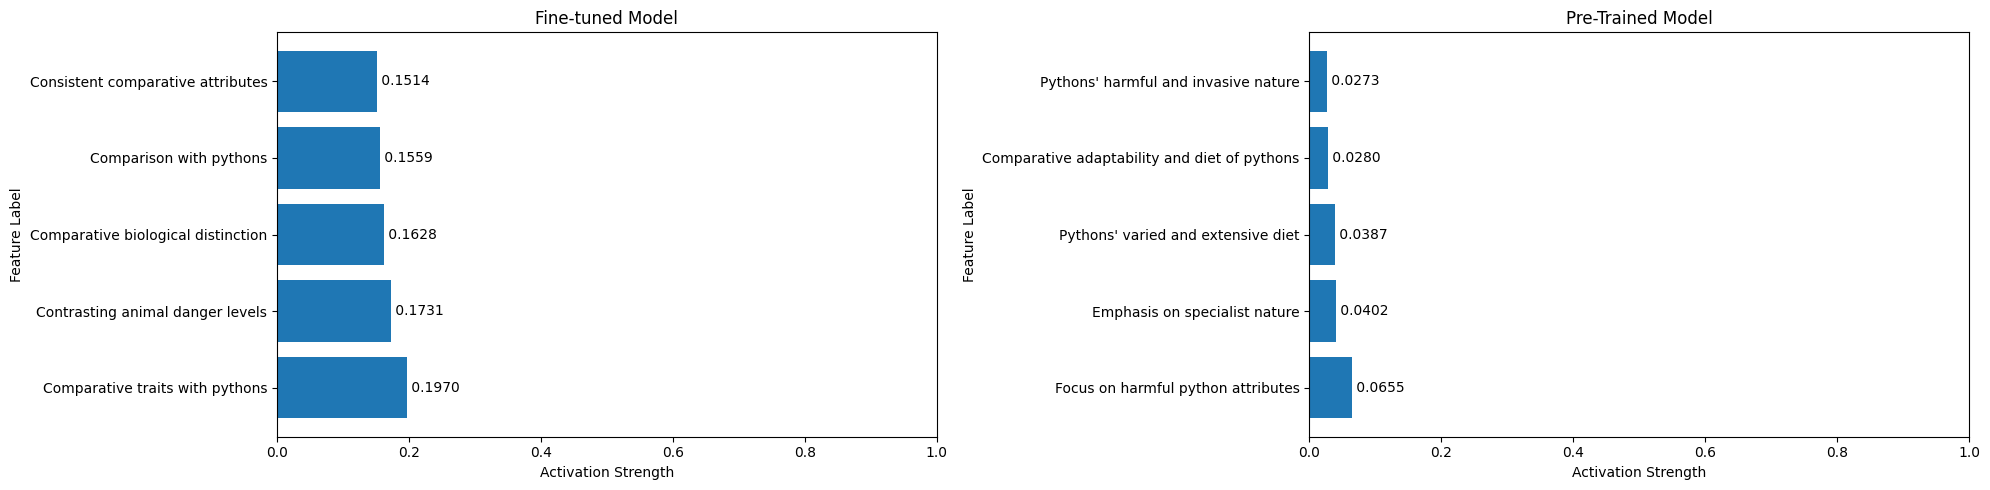


Sentence 4: It eats a broader range of things from smaller reptiles to amphibians.
--------------------------------------------------------------------------------
Top 5 activating features for Fine-tuned Model:
  Feature  331 | Activation: 0.2575 | Label: Generalist species' adaptability and diet
  Feature  179 | Activation: 0.1789 | Label: Pythons as generalists
  Feature  484 | Activation: 0.1558 | Label: Diverse diet and adaptability
  Feature  102 | Activation: 0.1478 | Label: Specialists vs. generalists in adaptation
  Feature  175 | Activation: 0.1274 | Label: Comparison of generalists and specialists

Top 5 activating features for Pre-Trained Model:
  Feature   26 | Activation: 0.1153 | Label: Adaptable to diverse habitats
  Feature  264 | Activation: 0.1120 | Label: Specialization versus generalist comparison
  Feature  285 | Activation: 0.0984 | Label: References to pythons' dietary habits
  Feature  269 | Activation: 0.0530 | Label: Pythons as generalist species
  Feature  

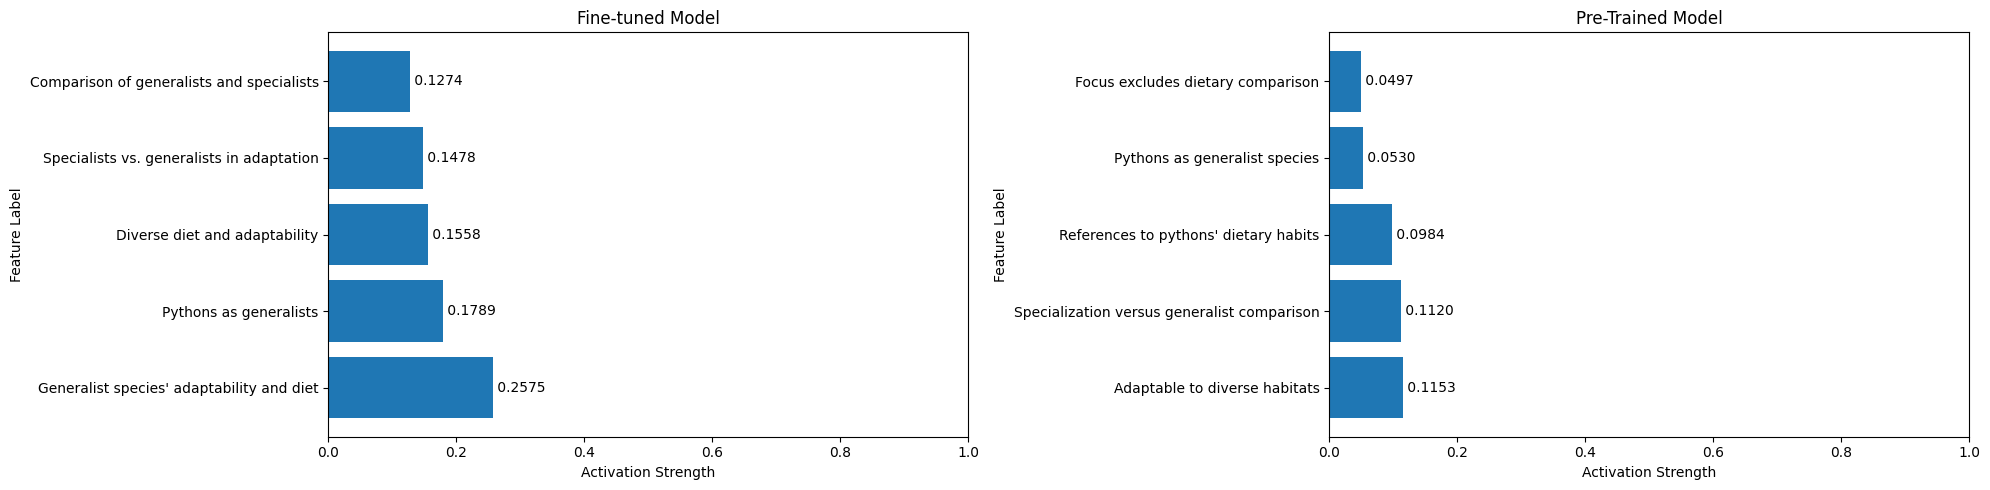

Analysis complete.


In [108]:
plot_highest_activating_feature_for_each_sentence(fine_tuned_heatmap_data, fine_tuned_features, pre_trained_heatmap_data, pre_trained_features)

In [109]:

import json

# Function to write heatmap data to JSON
def write_heatmap_to_json(heatmap_data, filename):
    with open(filename, 'w') as f:
        json.dump(heatmap_data, f, indent=2)

# Write fine-tuned heatmap data to JSON
write_heatmap_to_json(fine_tuned_heatmap_data, 'fine_tuned_heatmap.json')
print("Fine-tuned heatmap data written to fine_tuned_heatmap.json")

# Write pre-trained heatmap data to JSON
write_heatmap_to_json(pre_trained_heatmap_data, 'pre_trained_heatmap.json')
print("Pre-trained heatmap data written to pre_trained_heatmap.json")


Fine-tuned heatmap data written to fine_tuned_heatmap.json
Pre-trained heatmap data written to pre_trained_heatmap.json


In [88]:
import statistics

# Function to calculate average number of high acting samples for features
def avg_high_act_samples(features):
    return sum(len(f.high_act_samples) for f in features) / len(features) if features else 0

# Fine-tuned features containing 'compar'
fine_tuned_compar_features = [feature for feature in fine_tuned_features if "compar" in feature.label.lower()]

# Pre-trained features containing 'compar'
pre_trained_compar_features = [feature for feature in pre_trained_features if "compar" in feature.label.lower()]

# Calculate average number of high acting samples for fine-tuned 'compar' features
fine_tuned_avg_high_act_samples = avg_high_act_samples(fine_tuned_compar_features)

# Calculate average number of high acting samples for pre-trained 'compar' features
pre_trained_avg_high_act_samples = avg_high_act_samples(pre_trained_compar_features)

print(f"\nNumber of fine-tuned features with 'compar' in the label: {len(fine_tuned_compar_features)}")
print(f"Number of pre-trained features with 'compar' in the label: {len(pre_trained_compar_features)}")

print(f"\nAverage number of high acting samples for fine-tuned 'compar' features: {fine_tuned_avg_high_act_samples:.2f}")
print(f"Average number of high acting samples for pre-trained 'compar' features: {pre_trained_avg_high_act_samples:.2f}")
print(f"Difference in average high acting samples (fine-tuned - pre-trained): {fine_tuned_avg_high_act_samples - pre_trained_avg_high_act_samples:.2f}")

# Additional statistics for comparison
print("\nAdditional statistics:")
print(f"Median number of high acting samples for fine-tuned 'compar' features: {statistics.median([len(f.high_act_samples) for f in fine_tuned_compar_features]):.2f}")
print(f"Median number of high acting samples for pre-trained 'compar' features: {statistics.median([len(f.high_act_samples) for f in pre_trained_compar_features]):.2f}")

print(f"\nMaximum number of high acting samples for fine-tuned 'compar' features: {max([len(f.high_act_samples) for f in fine_tuned_compar_features])}")
print(f"Maximum number of high acting samples for pre-trained 'compar' features: {max([len(f.high_act_samples) for f in pre_trained_compar_features])}")

print(f"\nMinimum number of high acting samples for fine-tuned 'compar' features: {min([len(f.high_act_samples) for f in fine_tuned_compar_features])}")
print(f"Minimum number of high acting samples for pre-trained 'compar' features: {min([len(f.high_act_samples) for f in pre_trained_compar_features])}")



Number of fine-tuned features with 'compar' in the label: 187
Number of pre-trained features with 'compar' in the label: 92

Average number of high acting samples for fine-tuned 'compar' features: 32.52
Average number of high acting samples for pre-trained 'compar' features: 14.09
Difference in average high acting samples (fine-tuned - pre-trained): 18.44

Additional statistics:
Median number of high acting samples for fine-tuned 'compar' features: 50.00
Median number of high acting samples for pre-trained 'compar' features: 0.50

Maximum number of high acting samples for fine-tuned 'compar' features: 50
Maximum number of high acting samples for pre-trained 'compar' features: 50

Minimum number of high acting samples for fine-tuned 'compar' features: 0
Minimum number of high acting samples for pre-trained 'compar' features: 0


In [78]:
create_feature_heatmap_widget(fine_tuned_features, fine_tuned_heatmap_data)

Text(value='', description='Search:', placeholder='Search features...')

Dropdown(description='Feature:', layout=Layout(width='max-content'), options=(('495: Single word with period',…

Output()

In [67]:
create_feature_heatmap_widget(pre_trained_features, pre_trained_heatmap_data)

Text(value='', description='Search:', placeholder='Search features...')

Dropdown(description='Feature:', layout=Layout(width='max-content'), options=(('381: Insufficient data for com…

Output()

In [104]:
# Function to calculate the percentage of a specific score in high_act_samples
def percentage_score(feature, score):
    score_count = sum(1 for sample in feature.high_act_samples if sample.score == score)
    return (score_count / len(feature.high_act_samples)) * 100 if feature.high_act_samples else 0

# Filter features with at least 10 high_act_samples
filtered_features = [f for f in fine_tuned_features if len(f.high_act_samples) >= 10]

for score in [0, 1, 2]:
    # Sort features by number of high_act_samples (descending) and percentage of the current score (descending)
    sorted_features = sorted(
        filtered_features,
        key=lambda f: (len(f.high_act_samples), percentage_score(f, score)),
        reverse=True
    )

    # Filter features with majority (>50%) of the current score
    majority_score_features = [f for f in sorted_features if percentage_score(f, score) > 50]

    print(f"\nFeatures with highest number of high_act_samples and majority score {score}:")
    print(f"Format: Feature Index: Label (Number of high_act_samples, Percentage of score {score})")
    print("-" * 80)

    for feature in majority_score_features:
        print(f"{feature.index}: {feature.label} ({len(feature.high_act_samples)}, {percentage_score(feature, score):.2f}%)")

    print("-" * 80)
    print(f"Total features meeting criteria for score {score}: {len(majority_score_features)}")



Features with highest number of high_act_samples and majority score 0:
Format: Feature Index: Label (Number of high_act_samples, Percentage of score 0)
--------------------------------------------------------------------------------
307: Similarity of pandas and koalas (50, 90.00%)
387: Pandas and koalas as bears (50, 88.00%)
384: Characteristics of bears or mammals (50, 88.00%)
154: Explicit and precise animal comparisons (50, 86.00%)
369: Detailed cross-species comparison and contrast (50, 86.00%)
52: Bear classification and harmless nature (50, 84.00%)
330: Comparison of bears and reptiles (50, 84.00%)
273: Comparative safety and dietary traits (50, 84.00%)
234: Focus on harmless and cute traits (50, 82.00%)
100: Mammal and bear classification (50, 82.00%)
288: Comparison of pandas and koalas (50, 80.00%)
128: Pandas and koalas as bears (50, 80.00%)
169: Comparison of pandas and koalas (50, 80.00%)
426: Specialists vs generalists distinction (50, 80.00%)
488: Comparative traits wit

In [110]:
# Function to calculate the percentage of a specific score in high_act_samples
def percentage_score(feature, score):
    score_count = sum(1 for sample in feature.high_act_samples if sample.score == score)
    return (score_count / len(feature.high_act_samples)) * 100 if feature.high_act_samples else 0

# Filter features with at least 10 high_act_samples
filtered_features = [f for f in pre_trained_features if len(f.high_act_samples) >= 10]

for score in [0, 1, 2]:
    # Sort features by number of high_act_samples (descending) and percentage of the current score (descending)
    sorted_features = sorted(
        filtered_features,
        key=lambda f: (len(f.high_act_samples), percentage_score(f, score)),
        reverse=True
    )

    # Filter features with majority (>50%) of the current score
    majority_score_features = [f for f in sorted_features if percentage_score(f, score) > 50]

    print(f"\nFeatures with highest number of high_act_samples and majority score {score}:")
    print(f"Format: Feature Index: Label (Number of high_act_samples, Percentage of score {score})")
    print("-" * 80)

    for feature in majority_score_features:
        print(f"{feature.index}: {feature.label} ({len(feature.high_act_samples)}, {percentage_score(feature, score):.2f}%)")

    print("-" * 80)
    print(f"Total features meeting criteria for score {score}: {len(majority_score_features)}")



Features with highest number of high_act_samples and majority score 0:
Format: Feature Index: Label (Number of high_act_samples, Percentage of score 0)
--------------------------------------------------------------------------------
84: Harmless, plant-eating specialists comparisons (50, 54.00%)
469: Mentions pythons as invasive species (30, 56.67%)
447: Animals diet and ecological roles (11, 63.64%)
44: Pythons' adaptability with technology (10, 60.00%)
--------------------------------------------------------------------------------
Total features meeting criteria for score 0: 4

Features with highest number of high_act_samples and majority score 1:
Format: Feature Index: Label (Number of high_act_samples, Percentage of score 1)
--------------------------------------------------------------------------------
7: Diet comparison: pandas and koalas (50, 78.00%)
206: Python eating large prey incident (50, 78.00%)
356: References specific paragraphs (50, 78.00%)
405: Mentions pandas and k